In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from camb.dark_energy import DarkEnergyPPF

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.5 installed at /gpfs/home/kuzhong/work/cocoa_AS/Cocoa/.local/lib/python3.7/site-packages/camb-1.3.5-py3.7.egg/camb


 taurst, taurend =    204.76792977580729        596.50124417228085     
 taurst, taurend =    204.86810539227599        596.88661186742718     
  Time for corr lensing:    0.00534


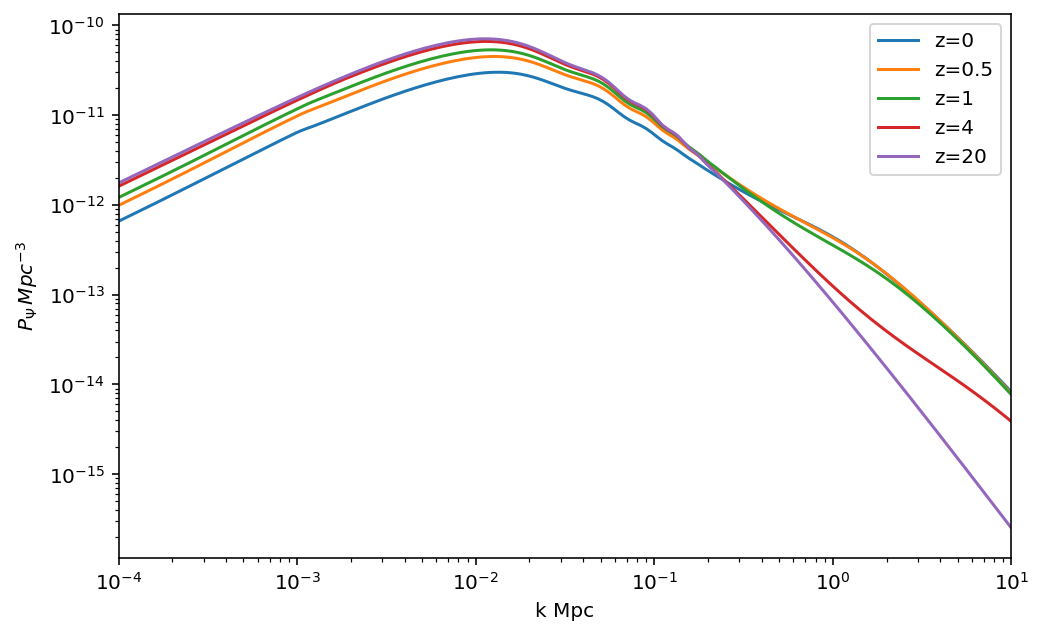

In [2]:
#For calculating large-scale structure and lensing results yourself, get a power spectrum
#interpolation object. In this example we calculate the CMB lensing potential power
#spectrum using the Limber approximation, using PK=camb.get_matter_power_interpolator() function.
#calling PK(z, k) will then get power spectrum at any k and redshift z in range.

nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)
pars.DarkEnergy = DarkEnergyPPF(w=-1.0, wa=0.0, g0_ppf = 1.0)

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)
#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#Here for lensing we want the power spectrum of the Weyl potential.
PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

#Have a look at interpolated power spectrum results for a range of redshifts
#Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
plt.figure(figsize=(8,5))
k=np.exp(np.log(10)*np.linspace(-4,2,200))
zplot = [0, 0.5, 1, 4 ,20]
for z in zplot:
    plt.loglog(k, PK.P(z,k))
plt.xlim([1e-4,kmax])
plt.xlabel('k Mpc')
plt.ylabel('$P_\Psi\, Mpc^{-3}$')
plt.legend(['z=%s'%z for z in zplot]);

In [3]:
#Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*win/k**4)
cl_kappa*= (ls*(ls+1))**2

 taurst, taurend =    204.78595109599129        596.70318141461860     
  Time for corr lensing:    0.00366


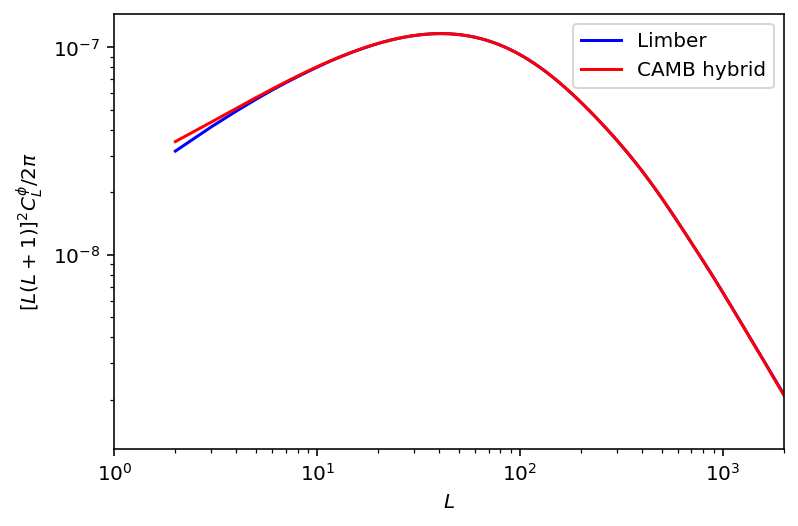

In [4]:
#Compare with CAMB's calculation:
#note that to get CAMB's internal calculation accurate at the 1% level at L~2000, 
#need lens_potential_accuracy=2. Increase to 4 for accurate match to the Limber calculation here
pars.set_for_lmax(2500,lens_potential_accuracy=2)
results = camb.get_results(pars)
cl_camb=results.get_lens_potential_cls(2500) 
#cl_camb[:,0] is phi x phi power spectrum (other columns are phi x T and phi x E)

#Make plot. Expect difference at very low-L from inaccuracy in Limber approximation, and
#very high L from differences in kmax (lens_potential_accuracy is only 2, though good by eye here)
cl_limber= 4*cl_kappa/2/np.pi #convert kappa power to [l(l+1)]^2C_phi/2pi (what cl_camb is)
plt.loglog(ls,cl_limber, color='b')
plt.loglog(np.arange(2,cl_camb[:,0].size),cl_camb[2:,0], color='r')
plt.xlim([1,2000])
plt.legend(['Limber','CAMB hybrid'])
plt.ylabel('$[L(L+1)]^2C_L^{\phi}/2\pi$')
plt.xlabel('$L$');